# Training Models with Unequal Economic Error Costs in Amazon SageMaker

***

## Table of Contents

1. [Introduction](#introduction)
1. [Background and Solution Overview](#background)
    1. [Importing Libraries](#libraries)
    1. [Defining Helper Functions](#helpers)
    1. [Importing Data](#import_data)
    1. [Preparing_Data](#process_data)
1. [Defining a Custom Loss Function](#custom_loss)
1. [Training the Model](#train)
1. [Building the Docker Image](#docker_image)
1. [Executing the Amazon SageMaker Training Job](#sagemaker_train)
1. [Making Predictions](#predictions)
1. [Analyzing the Results](#score)
1. [Conclusion](#conclusion)

The blog post associated with this notebook is located [here](#https://aws.amazon.com/blogs/machine-learning/training-models-with-unequal-economic-error-costs-using-amazon-sagemaker/).

### Introduction<a id='introduction'></a>

Many companies are turning to machine learning (ML) to improve customer and business outcomes. They use the power of ML models built over “big data” to identify patterns and find correlations. Then they can identify appropriate approaches or predict likely outcomes based on data about new instances. However, as ML models are approximations of the real world, some of these predictions will likely be in error. 

In some applications all types of prediction errors are truly equal in impact. In other applications, one kind of error can be much more costly or consequential than another – measured in absolute or relative terms, in dollars, time, or something else. For example, predicting someone does not have breast cancer when they do (a false negative error) will, according to medical estimates, likely have much greater cost or consequences than the reverse error. We may even be willing to tolerate more false positive errors if we sufficiently reduce the false negatives to compensate. 

In this blog post, we address applications with unequal error costs with the goal of reducing undesirable errors while providing greater transparency to the trade-offs being made. We show you how to train a model in Amazon SageMaker for a binary classification problem in which the costs of different kinds of misclassification are very different. To explore this tradeoff, we show you how to write a custom loss function – the metric that evaluates how well a model makes predictions – that incorporates asymmetric misclassification costs. We then show you how to train an Amazon SageMaker Build Your Own Model using that loss function. Further, we show how to evaluate the errors made by the model and how to compare models trained with different relative costs so that you can identify the model with the best economic outcome overall.

The advantage of this approach is that it makes an explicit link between an ML model’s outcomes and errors and the business’ framework for decision-making. This approach requires the business to explicitly state its cost matrix, based on the specific actions to be taken on the predictions. The business can then evaluate the economic consequences of the model predictions on their overall processes, the actions taken based on the predictions, and their associated costs. This evaluation process moves well beyond simply assessing the classification results of the model. This approach can drive challenging discussions in the business, and force differing implicit decisions and valuations onto the table for open discussion and agreement.

### Background and Solution Overview<a id='background'></a>

Although model training always aims to minimize errors, most models are trained to assume that all types of errors are equal. However, what if we know that the costs of different types of errors are not equal? For example, let's take a sample model trained on [UCI'S breast cancer diagnostic data set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29).<sup>[1](#note_one)</sup> Clearly, a false positive prediction (predicting this person has breast cancer, when they do not) has very different consequences than a false negative prediction (predicting this person does not have breast cancer, when they do). In the first case, the consequence is an extra round of screening. In the second case, the cancer might be at a more advanced stage before it's discovered. To quantify these consequences they are often discussed in terms of their relative cost, which then allows trade-offs to be made. While we can debate what the exact costs of a false negative or a false positive prediction should be, we believe we’d all agree that they're not the same - although ML models are generally trained as if they are. 
 
We can use a custom cost function to evaluate a model and see the economic impact of the errors the model is making (utility analysis). Elkan<sup>[2](#note_two)</sup> showed that applying a cost function to the results of a model can be used to compensate for imbalanced samples when used in standard Bayesian and decision tree learning methods (for example: few loan defaults, versus a large sample of repaid loans). The custom function can also be used to perform this same compensation.

We can also have the model “shift” its predictions in a fashion that reflects the difference in cost, by providing the costs of different types of errors to the model during training using a custom loss function. So, for example, in the breast cancer example we'd like the model to make fewer false negative errors and are willing to accept more false positives to achieve that goal. We may even be willing to give up some “correct” predictions in order to have fewer false negatives. At least, we'd like to understand the trade-offs we can make here. In our example, we'll use costs from the healthcare industry.<sup>[3](#note_three),[4](#note_four)</sup> 

In addition, we'd like to understand in how many cases the model's predictions are “almost” predicted as something else. For example, binary models use a cutoff (say, 0.5) to classify a score as “True” or "False." How many of our cases were in fact very close to the cut-off? Are our false negatives classified that way because their score was 0.499999? These details can’t be seen in the usual representations of confusion matrices or AUC measures. To help address these questions, we have developed a novel, graphical representation of the model predictions that allows us to examine these details, without depending on a specific threshold.

In fact, there are likely cases where a model trained to avoid specific types of errors would begin to specialize in differentiating errors. Imagine a neural network that's been trained to believe that all misrecognitions of street signs are equal.<sup>[5](#note_five)</sup> Now, imagine a neural network that's been trained that misrecognizing a stop sign as a sign for speed limit 45 mph is a far worse error than confusing two speed limit signs. It's reasonable to expect that the neural network would begin to recognize different features. We believe this is a promising research direction. 

We use Amazon SageMaker to build and host our model. Amazon SageMaker is a fully-managed platform that enables developers and data scientists to quickly and easily build, train, and deploy machine learning models at any scale. We author and analyze the model in a Jupyter notebook hosted on an Amazon SageMaker notebook instance, then build and deploy an endpoint for online predictions, using its “Bring Your Own Model” capability.

Note that while the terms "cost function" and "loss function" are often used interchangeably, we differentiate between them in this post, and provide examples of each:

* We use a "loss function" to train the model. Here, we specify the different weights of different kinds of errors. The relative weight of the errors is of most importance here.
* We use a "cost function" to evaluate the economic impact of the model. For the cost function, we can specify the cost (or value) of correct predictions, as well as the cost of errors. Here, dollar costs are most appropriately used.

This distinction allows us to further refine the model's behavior or to reflect differing influences from different constituencies. Although in this model we'll use the same set of costs (quality adjusted life years, QALY) for both functions, you could, for example, use relative QALY for the loss function, and costs of providing care for the cost function.

We’ll break up this problem into three parts:
1.	In "Defining a custom loss function," we show how to build a custom loss function that weights different errors unequally. The relative costs of the prediction errors are provided as hyperparameters at runtime, allowing the effects of different weightings on the model to be explored and compared. We build and demonstrate the use of a custom cost function to evaluate our “vanilla” model, which is trained to assume that all errors are equal.
2.	In “Training the model,” we demonstrate how to train a model by using the custom loss function. We emulate and extend a [sample notebook](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_applying_machine_learning/breast_cancer_prediction), which uses the UCI breast cancer diagnostic data set.
3.	In “Analyzing the results,” we show how we can compare the models to better understand the distribution of predictions as compared to our threshold. We'll see that by training the model to avoid certain kinds of errors, we'll affect the distributions so that the model differentiates more effectively between its positive and negative predictions.

We are building our own model and not using one of the Amazon SageMaker built-in algorithms. This means that we can make use of the Amazon SageMaker ability to train any custom model as long as it’s packaged in a Docker container with the image of that container available in Amazon Elastic Container Registry (Amazon ECR). For details on how to train a custom model on Amazon SageMaker, see [this post](https://aws.amazon.com/blogs/machine-learning/train-and-host-scikit-learn-models-in-amazon-sagemaker-by-building-a-scikit-docker-container/) or the various [sample notebooks available](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/advanced_functionality).

Bibliography:

1.<a id='note_one'></a> Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

2.<a id='note_two'></a> Elkan, Charles. “The Foundations of Cost-Sensitive Learning.” In International Joint Conference on Artificial Intelligence, 17:973–978. Lawrence Erlbaum Associates Ltd, 2001.

3.<a id='note_three'></a> Wu, Yirong, Craig K. Abbey, Xianqiao Chen, Jie Liu, David C. Page, Oguzhan Alagoz, Peggy Peissig, Adedayo A. Onitilo, and Elizabeth S. Burnside. “Developing a Utility Decision Framework to Evaluate Predictive Models in Breast Cancer Risk Estimation.” Journal of Medical Imaging 2, no. 4 (October 2015). https://doi.org/10.1117/1.JMI.2.4.041005.

4.<a id='note_four'></a> Abbey, Craig K., Yirong Wu, Elizabeth S. Burnside, Adam Wunderlich, Frank W. Samuelson, and John M. Boone. “A Utility/Cost Analysis of Breast Cancer Risk Prediction Algorithms.” Proceedings of SPIE--the International Society for Optical Engineering 9787 (February 27, 2016). 

5.<a id='note_five'></a> Eykholt, Kevin, Ivan Evtimov, Earlence Fernandes, Bo Li, Amir Rahmati, Chaowei Xiao, Atul Prakash, Tadayoshi Kohno, and Dawn Song. “Robust Physical-World Attacks on Deep Learning Models.” ArXiv:1707.08945 [Cs], July 27, 2017. http://arxiv.org/abs/1707.08945.![image.png](attachment:image.png)

### Setup

To set up the environment necessary to run this example in your own AWS account, first follow Steps 0 and 1 in this [previously published blog post](https://aws.amazon.com/blogs/machine-learning/simulate-quantum-systems-on-amazon-sagemaker/) to set up an Amazon SageMaker instance and add the AmazonEC2ContainerRegistryFullAccess policy to the SageMakerExecutionRole. Then, as in Step 2, open a terminal to clone our Git repo into your Amazon SageMaker notebook instance.

The repo contains a directory named "container" that has all the components necessary to build and use a Docker image of the algorithm we run in this blog post. You can find more information on the individual components in [this Amazon SageMaker sample notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/scikit_bring_your_own/scikit_bring_your_own.ipynb). For our purposes, there are two files that are most relevant and contain all the information to run our workload.
1. Dockerfile. This file describes how to build your Docker container image. Here you can define the dependencies of your code, for example, which language you are using (Python), what packages your code needs (for example, TensorFlow), and so on. More details can be found [here](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/scikit_bring_your_own/scikit_bring_your_own.ipynb).
1. custom_loss/train. This file is executed when Amazon SageMaker runs the container for training. It contains the Python code that defines the binary classifier model, the custom loss function used to train the model and Keras training job. We describe this code in more detail below.

#### Importing Libraries<a id='libraries'></a>

In [1]:
import keras
import io
import os
import time
import sagemaker.amazon.common as smac
import sagemaker as sage
import boto3 as aws
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
role = sage.get_execution_role()

The S3 folder that will contain both the training data and model output is called 'custom-loss-sagemaker' here. You will need to create your own S3 bucket with a globally unique name. 

Create a bucket with a name like 'custom-loss-sagemaker' + your name. Once that bucket is created, update the bucket variable below.

In [5]:
bucket = 'custom-loss-sagemaker'   # UPDATE THIS 
prefix = 'custom-loss-blog-post'

This is the name that will be associated with the Docker image created in this notebook.

In [5]:
image_name = 'custom-loss'

This cutoff (aka threshold) will be used to construct the confusion matrices and to color the distribution plots in the "Analyzing the Results" section of this notebook.

In [6]:
cutoff = 0.5

#### Defining Helper Functions<a id='helpers'></a>

In this section, we define several helper functions that calculate various metrics used to judge the quality of the model. See top of each function for a detailed description of its purpose.

In [7]:
def custom_pred_distro(positives, negatives, cutoff=0.5, title=None):
    '''This function generates distributions of predicted scores for actual positives and actual negatives. 
    
    Note that the cutoff argument only affects the coloring of the graphs. It does NOT affect any model
    results or predicted values.'''

    fig, axes = plt.subplots(2,1, figsize=(10,8))

    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    axes[0].set(xlim=[0,1], xticks=np.arange(0, 1, step=0.1), xlabel='Model Score', ylabel='Count', title='Actual Negatives')
    axes[0].hist(negatives[negatives>cutoff], color='C1', label='False Positives', bins=30)
    axes[0].hist(negatives[negatives<=cutoff], label='True Negatives', bins=30)
    axes[0].legend()
    
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].set(xlim=[0,1], xticks=np.arange(0, 1, step=0.1), xlabel='Model Score', ylabel='Count', title='Actual Positives')
    axes[1].hist(positives[positives>cutoff], label='True Positives', bins=30)
    axes[1].hist(positives[positives<=cutoff], label='False Negatives', bins=30)
    axes[1].legend()
    
    if title is not None:
        fig.suptitle(title, fontsize=16, fontweight='bold', x=0.52)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    else:
        plt.tight_layout()
    
    return None

In [8]:
def expected_value(positives, negatives, v_tn, v_fp, v_fn, v_tp, cutoff=0.5):
    '''This function calculates the expected value of the next test example. To do this, the function must calculate 
    the prob of classification/misclassification errors and that requires using a cutoff value to make discrete predictions.'''
    
    tp = (positives > cutoff).sum()
    fn = (positives <= cutoff).sum()

    tn = (negatives < cutoff).sum()
    fp = (negatives >= cutoff).sum()
    
    pos = fn + tp
    neg = fp + tn
    total = tn + fp + fn + tp
    
    fpr = fp/neg
    fnr = fn/pos
    
    n = neg/total 
    p = pos/total
    
    #given truth is negative
    ev_n = v_tn * (1-fpr) + v_fp * (fpr)
    #given truth is positive
    ev_p = v_tp * (1-fnr) + v_fn * (fnr)
    
    #total expected value
    ev = ev_n * n + ev_p * p 
    
    output = {
        'fpr': fpr,
        'fnr': fnr,
        'n': n,
        'p': p,
        'ev_n': ev_n,
        'ev_p': ev_p,
        'ev': ev
    }
    
    return output

In [9]:
def conf_matrix(positives, negatives, cutoff, title):
    '''This function draws a confusion matrix, using our cutoff.'''
 
    tp = (positives > cutoff).sum()
    fn = (positives <= cutoff).sum()

    tn = (negatives < cutoff).sum()
    fp = (negatives >= cutoff).sum()
    
    output = {
        'Predicted Negatives': [tn, fn],
        'Predicted Positives': [fp, tp]
    }
    
    df_table = pd.DataFrame(output, index=['Actual Negatives', 'Actual Positives'])

    display(HTML('<b>' + title + '</b>'))
    display(HTML(df_table.to_html()))

#### Importing the Data<a id='import_data'></a>

Here we import the breast cancer screening data used to construct our model.

In [10]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header = None)

# specify columns extracted from wbdc.names
data.columns = ["id","diagnosis","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean",
                "compactness_mean","concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean",
                "radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se",
                "concave points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst",
                "perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst",
                "concave points_worst","symmetry_worst","fractal_dimension_worst"] 

# save the data
data.to_csv("data.csv", sep=',', index=False)

# print the shape of the data file
print(data.shape)

# show the top few rows
display(data.head())

# describe the data object
display(data.describe())

# we will also summarize the categorical field diganosis 
display(data.diagnosis.value_counts())

(569, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


B    357
M    212
Name: diagnosis, dtype: int64

#### Preparing the Data<a id='process_data'></a>

We split the data into training and test sets.

In [11]:
X = data.drop('id', axis=1)
y = X.pop('diagnosis')

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

We standardize the data since variance differs drastically across features and map the target variable to numeric values.

In [12]:
scaler = StandardScaler().fit(x_train)

x_train_scld = scaler.transform(x_train)
x_test_scld = scaler.transform(x_test)

In [13]:
label_map = {'M': 1, 'B': 0 }
y_train = y_train.map(label_map)
y_test = y_test.map(label_map)

In [14]:
training_data = np.concatenate((y_train.values.reshape((426,1)), x_train_scld), axis=1)

Since Amazon SageMaker expects the training data to be read from an S3 bucket, we save the training data to the S3 bucket defined at the top of this notebook.

In [ ]:
#first save the training data as a csv locally
training_data_name = 'training_data.csv'
np.savetxt(training_data_name, training_data, delimiter=',')

In [16]:
#then load data into S3
aws.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', training_data_name))\
    .upload_file(training_data_name)

### Defining a Custom Loss Function<a id='custom_loss'></a>

WWe now construct a loss function that weighs false positive errors differently from false negatives one. To do this, we build a binary classifier in Keras to use Keras' ability to accommodate user-defined loss functions.

To build a loss function in Keras, we define a Python function that takes model predictions and ground-truth as arguments and returns a scalar value. In the custom function, we input the cost associated with a false negative error (fn_cost) and with a false positive error (fp_cost). Note that internally the loss function must use Keras backend functions to perform any calculations.

The following function defines the loss of a single prediction as the difference between the prediction's ground-truth class and the predicted value weighted by the cost associated with misclassifying an observation from that ground-truth class. The total loss is the unweighted average of all of these losses. This is a relatively simple loss function, but building upon this foundation, more complex, situation-specific benefit and cost structures can be constructed and used to train models.

```
def custom_loss_wrapper(fn_cost=1, fp_cost=1):
        
    def custom_loss(y_true, y_pred, fn_cost=fn_cost, fp_cost=fp_cost):
   
        h = K.ones_like(y_pred)
        fn_value = fn_cost * h
        fp_value = fp_cost * h

        weighted_values = y_true * K.abs(1-y_pred)*fn_value + (1-y_true) * K.abs(y_pred)*fp_value

        loss = K.mean(weighted_values)
        return loss
        
    return custom_loss
```

### Training the Model<a id='train'></a>

Since we are using Amazon SageMaker to train a custom model, all of the code related to building and training the model is located in a Docker container image stored in Amazon ECR. The code shown here is an example of the code contained in the Docker container image.

The files containing the actual model code (and custom loss function, mirroring the copy shown earlier) as well as all the files necessary to create the Docker container image and push it to Amazon ECR are located in the [repository associated with this blog post](#https://github.com/aws-samples/amazon-sagemaker-custom-loss-function).

We construct and train three models so we can compare the predictions of various models using Keras' built-in loss function as well as our custom loss function. We use a binary classification model that predicts the probability that a tumor is malignant.

The three models are:
1.	A binary classification model that uses Keras' built-in binary cross-entropy loss with equal weights for false negative and false positive errors.
2.	A binary classification model that uses the custom loss function defined previously with false negatives weighted 5 times as heavily as false positives.
3.	A binary classification model that uses the custom loss function defined previously with false negatives weighted 200 times as heavily as false positives.

The costs used in the last model's loss function are based upon the medical literature.3,4 The costs of screening are measured in QALYs. One QALY is defined as one year of life in full health (1 year x 1.0 health). For example, if an individual is at half health, that is, 0.5 of full health, then one year of life for that individual is equal to 0.5 QALYs (1 year x 0.5 health). Two years of life for that individual is worth 1 QALY (2 years x 0.5 health).

| Outcome |	QALY |
|----|---|
|True Negative |	0 |
|False Positive|	-0.01288|
| True Positive|	-0.3528|
|False Negative	|-2.52|

Here, a true negative outcome is measured as the baseline of costs, that is, all other costs in the table are measured relative to a patient without breast cancer that tests negative for breast cancer. A woman with breast cancer that tests negative loses 2.52 QALYs relative to the baseline, and a woman without breast cancer that tests positive loses 0.0128767 QALYs (or about 4.7 days) relative to the baseline. A QALY has an estimated economic value of $100,000 USD. So these values can also be translated into dollar costs by multiplying the cost in QALYs by 100,000 USD. Given these values, a false negative error is about 200 times more costly than a false positive one. See the medical literature referenced in the introduction for more detail surrounding these costs.

The middle model value of 5 was chosen for demonstration purposes.

With these costs in hand, we can now estimate the model. Estimating the parameters of a model in Keras is a three-step process:
1.	Defining the model.
2.	Compiling the model.
3.	Training the model.

#### Defining the Model Architecture

First, we define the structure of the model. In this case, the model consists of a single node in a single layer. That is, for each model that follows, we add a single Dense layer with a single unit that takes a linear combination of features and passes that linear combination to a sigmoid function that outputs a value between 0 and 1. Again, the actual executable version of the code is in the Docker container, but is shown here for illustrative purposes.

We'll provide the relative weights in a later step.

```
#The 'built-in' model is trained on Keras' built-in binary crossentropy loss function.
model_builtin = Sequential()
model_builtin.add(Dense(units=num_classes, input_dim=input_dim,  activation='sigmoid'))

#The 'custom' model is trained on our custom loss function that weighs 
#false negatives 5 time's more heavily than false positives.
model_five = Sequential()
model_five.add(Dense(units=num_classes, input_dim=input_dim,  activation='sigmoid'))

#The 'medical' model is trained on our custom loss function that assigns weights 
#false negatives and false positives derived from the medical literature.
model_medical = Sequential()
model_medical.add(Dense(units=num_classes, input_dim=input_dim,  activation='sigmoid'))
```

#### Compiling Model

Next, let's compile the models. Compiling a model refers to configuring the learning process. We need to specify the optimization algorithm and the loss function that we will use to train the model. 

This is the step in which we incorporate our custom loss function and relative weights into the model training process. 

```
#Trained using built-in loss function
model_builtin.compile(loss='binary_crossentropy',
             optimizer='sgd',
             metrics=['accuracy'])


#Trained using custom loss function with false negatives weighted 5 times more heavily than false positives
custom_loss_five = custom_loss_wrapper(fn_cost=5, fp_cost=1)

model_five.compile(loss=custom_loss_five,
             optimizer='sgd',
             metrics=['accuracy'])

#Trained using custom loss function with false negatives weighted about 200 times more heavily than false positives
custom_loss_medical = custom_loss_wrapper(fn_cost=200, fp_cost=1)

model_medical.compile(loss=custom_loss_medical,
             optimizer='sgd',
             metrics=['accuracy'])
```

#### Training the Model

Now we’re ready to train the models. To do this, we call the fit method and provide the training data, number of epochs, and batch size. Whether you use a built-in or a custom loss function, the code is the same in this step.

```
model_builtin.fit(train_x, train_y, epochs=50, batch_size=32, verbose=0)
model_five.fit(train_x, train_y, epochs=50, batch_size=32, verbose=0)
model_medical.fit(train_x, train_y, epochs=50, batch_size=32, verbose=0)
```

### Building the Docker Image<a id='docker_image'></a>

By the executing the line of code below, we are building the Docker image that contains the custom loss function and model code and pushing image to Amazon Elastic Container Registry (ECR). The "image_name" defined at the top of this notebook is the name that will be assigned to the repository in ECR that contains this image.

In [17]:
! ./build_and_push.sh {image_name}

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
Login Succeeded
Sending build context to Docker daemon  2.803MB
Step 1/8 : FROM tensorflow/tensorflow:1.9.0
1.9.0: Pulling from tensorflow/tensorflow
Digest: sha256:92ad7f5da1f0e7c2c7b714b77b12424ae3d7971510d8ff8673b8b0695c3fd1c9
Status: Downloaded newer image for tensorflow/tensorflow:1.9.0
 ---> caab7ec02690
Step 2/8 : MAINTAINER Scott Gregoire <sggregoi@amazon.com>
 ---> Using cache
 ---> 93b5c47e577b
Step 3/8 : RUN pip install keras==2.2.0 h5py==2.8.0 pandas==0.22.0
 ---> Running in 21d4fd23fbe8
  Running setup.py bdist_wheel for pyyaml: started
  Running setup.py bdist_wheel for pyyaml: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/ad/da/0c/74eb680767247273e2cf2723482cb9c924fe70af57c334513f
Successfully built pyyaml
  Found existing installation: pandas 0.23.3
    Uninstalling pandas-0.23.3:
      Successfully uninstalled pandas-0.23.3
You are using pip version 10.0.1, however ver

### Executing the Amazon SageMaker Training Job<a id='sagemaker_train'></a>

As mentioned previously, we perform the actual training of the binary classifier by packaging the model definition and training code in a Docker container and using the Amazon SageMaker bring-your-own-model training functionality to estimate the model's parameters.

The following code blocks train three versions of the classifier:
1.	One with Keras' built-in binary_cross-entropy loss function.
2.	One with a custom loss function that weighs false negatives 5 times more heavily than false positives.
3.	One with a custom loss function that weighs false negatives 200 times more heavily than false positives.

#### Builtin Loss Function Model

We specify parameters of the Amazon SageMaker training job: the Amazon SageMaker role, account, region, and the specify container image to use to train the classifier

In [18]:
sess = sage.Session()

account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = '{}.dkr.ecr.{}.amazonaws.com/{}:latest'.format(account, region, image_name)

We create and execute an Amazon SageMaker training job for builtin loss function, that is, Keras's binary cross-entropy loss function. By passing the "loss_function_type" set to "builtin", Amazon SageMaker knows to use Keras's binary cross-entropy loss function.

In [19]:
#Specify type of loss function with which to train the model. Specify false negative and false negative costs
#if using a custom loss function
hyperparameters_builtin = {
            "loss_function_type": "builtin"
        }

model_builtin = sage.estimator.Estimator(image_name=image,
                    role=role,
                    train_instance_count=1,
                    train_instance_type='ml.c4.2xlarge',
                    output_path="s3://{}/{}/output".format(bucket, prefix),
                    hyperparameters=hyperparameters_builtin,
                    sagemaker_session=sess)

In [20]:
model_builtin.fit({'train':"s3://{}/{}/train".format(bucket, prefix)})

INFO:sagemaker:Creating training-job with name: custom-loss-2018-08-06-17-04-51-897


..............
Using TensorFlow backend.
Starting the training.
loss_function_type:  builtin
2018-08-06 17:06:56.168077: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Saved trained model at /opt/ml/model 
===== Job Complete =====
Billable seconds: 56


#### 5:1 Custom Loss Function Model

We create and execute an Amazon SageMaker training job for the custom 5:1 loss function, that is, custom loss with false negatives being 5 times more costly than false positives. By passing the "loss_function_type" set to "custom" and "fn_cost" to "5" and "fp_cost" to "1", respectively, Amazon SageMaker knows to use the custom loss function with the specified misclassification costs.

In [21]:
#Specify type of loss function with which to train the model. Specify false negative and false negative costs
#if using a custom loss function
hyperparameters_five = {
            "loss_function_type": "custom",
            "fn_cost": 5,
            "fp_cost": 1
        }

model_five = sage.estimator.Estimator(image_name=image,
                    role=role,
                    train_instance_count=1,
                    train_instance_type='ml.c4.2xlarge',
                    output_path="s3://{}/{}/output".format(bucket, prefix),
                    hyperparameters=hyperparameters_five,
                    sagemaker_session=sess)

In [22]:
model_five.fit({'train':"s3://{}/{}/train".format(bucket, prefix)})

INFO:sagemaker:Creating training-job with name: custom-loss-2018-08-06-17-07-33-390


...............
Using TensorFlow backend.
Starting the training.
fn_cost:  5
fp_cost:  1
loss_function_type:  custom
2018-08-06 17:09:58.471933: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Saved trained model at /opt/ml/model 
===== Job Complete =====
Billable seconds: 59


#### Medical Custom Loss Function Model

We create and execute an Amazon SageMaker training job for custom 200:1 loss function, that is, custom loss with false positives being 200 times more costly than false positives. By passing the "loss_function_type" set to "custom" and "fn_cost" to "200" and "fp_cost" to "1", respectively, Amazon SageMaker knows to use the custom loss function with the specified misclassification costs.

In [23]:
#Specify type of loss function with which to train the model. Specify false negative and false negative costs
#if using a custom loss function
hyperparameters_medical = {
            "loss_function_type": "custom",
            "fn_cost": 200,
            "fp_cost": 1
        }

model_medical = sage.estimator.Estimator(image_name=image,
                    role=role,
                    train_instance_count=1,
                    train_instance_type='ml.c4.2xlarge',
                    output_path="s3://{}/{}/output".format(bucket, prefix),
                    hyperparameters=hyperparameters_medical,
                    sagemaker_session=sess)

In [24]:
model_medical.fit({'train':"s3://{}/{}/train".format(bucket, prefix)})

INFO:sagemaker:Creating training-job with name: custom-loss-2018-08-06-17-10-45-209


..............
Using TensorFlow backend.
Starting the training.
fn_cost:  200
fp_cost:  1
loss_function_type:  custom
2018-08-06 17:12:48.586455: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Saved trained model at /opt/ml/model 
===== Job Complete =====
Billable seconds: 58


### Making Predictions<a id='predictions'><a>

After training the model, Amazon SageMaker uploads the trained model artifact to the S3 bucket we specifed in the output_path parameter in the training jobs. We now load the model artifacts from S3 and make predictions with all three models variants, then compare results.

#### Loading Builtin Loss Function Model

In [25]:
#We load the trained model locally
builtin_tar_name = '{}/output/{}/output/model.tar.gz'.format(prefix, model_builtin.latest_training_job.job_name)
aws.resource('s3').Bucket(bucket).download_file(builtin_tar_name, 'model_builtin.tar.gz')

#Amazon SageMaker creates a tarred model artifact so to reconstruct the model, we first need to untar the model.
!mkdir builtin_model
trained_model_builtin = !tar xzvf 'model_builtin.tar.gz' -C 'builtin_model'

#We then rebuild Keras model from the Amazon SageMaker model artifact.
arch_builtin = [x for x in trained_model_builtin if 'json' in x][0]
weights_builtin = [x for x in trained_model_builtin if 'h5' in x][0]

with open('builtin_model/' + arch_builtin, 'rb') as f:
    model_load_builtin = keras.models.model_from_json(f.read())
model_load_builtin.load_weights('builtin_model/' + weights_builtin)

#### Loading 5:1 Custom Loss Function Model

In [26]:
#We load the trained model locally
five_tar_name = '{}/output/{}/output/model.tar.gz'.format(prefix, model_five.latest_training_job.job_name)
aws.resource('s3').Bucket(bucket).download_file(five_tar_name, 'model_five.tar.gz')

#Amazon SageMaker creates a tarred model artifact so to reconstruct the model, we first need to untar the model.
!mkdir five_model
trained_model_five = !tar xzvf 'model_five.tar.gz' -C 'five_model'

#We then rebuild Keras model from the Amazon SageMaker model artifact.
arch_five = [x for x in trained_model_five if 'json' in x][0]
weights_five = [x for x in trained_model_five if 'h5' in x][0]

with open('five_model/' + arch_five, 'r') as f:
    model_load_five = keras.models.model_from_json(f.read())
model_load_five.load_weights('five_model/' + weights_five)

#### Loading Medical Custom Loss Function Model

In [27]:
#We load the trained model locally
medical_tar_name = '{}/output/{}/output/model.tar.gz'.format(prefix, model_medical.latest_training_job.job_name)
aws.resource('s3').Bucket(bucket).download_file(medical_tar_name, 'model_medical.tar.gz')

#Amazon SageMaker creates a tarred model artifact so to reconstruct the model, we first need to untar the model.
!mkdir medical_model
trained_model_medical = !tar xzvf 'model_medical.tar.gz' -C 'medical_model'

#We then rebuild Keras model from the Amazon SageMaker model artifact.
arch_medical = [x for x in trained_model_medical if 'json' in x][0]
weights_medical = [x for x in trained_model_medical if 'h5' in x][0]

with open('medical_model/' + arch_medical, 'r') as f:
    model_load_medical = keras.models.model_from_json(f.read())
model_load_medical.load_weights('medical_model/' + weights_medical)

#### Making Predictions

In [28]:
#continuous and discrete predictions for builtin loss function model
y_builtin_pred = model_load_builtin.predict(x_test_scld)
y_builtin_pred_discrete = y_builtin_pred > cutoff

#continuous and discrete predictions for 5:1 custom loss function model
y_five_pred = model_load_five.predict(x_test_scld)
y_five_pred_discrete = y_five_pred > cutoff

#continuous and discrete predictions for 200:1 custom  loss function model
y_medical_pred = model_load_medical.predict(x_test_scld)
y_medical_pred_discrete = y_medical_pred > cutoff

In [29]:
#here we divide the model predictions based upon whether ground-truth is positive or negative
y_builtin_pred_pos = y_builtin_pred[y_test==1]
y_builtin_pred_neg = y_builtin_pred[y_test==0]

y_five_pred_pos = y_five_pred[y_test==1]
y_five_pred_neg = y_five_pred[y_test==0]

y_medical_pred_pos = y_medical_pred[y_test==1]
y_medical_pred_neg = y_medical_pred[y_test==0]

### Analyzing the Results<a id='analyze'></a>

What characteristics are we generally looking for in a well-performing model?

1.	There should be a small number of false negatives, that is, a small number of malignant tumors classified as benign. 
2.	Predictions should cluster closely around ground truth values, that is, predictions should cluster closely around 0 and 1.

Keep in mind as you rerun this notebook that the data set used is small (569 instances), and therefore the test set is even smaller (143 instances). Because of this, the exact distribution of predictions and prediction errors of the model may vary from run to run due to sampling error. Despite this, the following general results hold across model runs.

#### Accuracy and the ROC Curve

First, we'll show traditional measures of the model. Here, we generate Accuracy and AUC values for all three models.

In [30]:
acc_builtin = accuracy_score(y_test, y_builtin_pred_discrete)
acc_five = accuracy_score(y_test, y_five_pred_discrete)
acc_medical = accuracy_score(y_test, y_medical_pred_discrete)

In [31]:
auc_builtin = roc_auc_score(y_test, y_builtin_pred)
auc_five = roc_auc_score(y_test, y_five_pred)
auc_medical = roc_auc_score(y_test, y_medical_pred)

In [32]:
pd.DataFrame({'Accuracy': [acc_builtin, acc_five, acc_medical], 'AUC': [auc_builtin, auc_five, auc_medical]} , index=['Built-in', '5:1', 'Medical'])

,AUC,Accuracy
Built-in,0.985537,0.937063
5:1,0.986983,0.909091
Medical,0.983264,0.846154


Now, we'll generate ROC curves for all three models.

In [33]:
fpr_builtin, tpr_builtin, thresholds_builtin = roc_curve(y_test, y_builtin_pred)
fpr_five, tpr_five, thresholds_five = roc_curve(y_test, y_five_pred)
fpr_medical, tpr_medical, thresholds_medical = roc_curve(y_test, y_medical_pred)

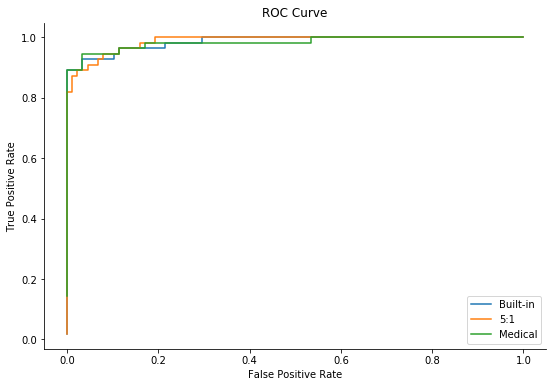

In [34]:
fig, axes = plt.subplots(1,1, figsize=(9, 6))

axes.set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC Curve')

axes.plot(fpr_builtin, tpr_builtin, label='Built-in')
axes.plot(fpr_five, tpr_five, label='5:1')
axes.plot(fpr_medical, tpr_medical, label='Medical')

axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

axes.legend()

By these traditional measures, the two custom loss function models do not perform as well as the built-in loss function (by a small margin).

However: accuracy is less relevant in judging the quality of these models. In fact, accuracy may be lowest in the "best" model because we are willing to have more false positives as long as we decrease the number of false negatives sufficiently.

Looking at the ROC curve and AUC score for these three models, all models appear very similar according to these measures. However, neither of these metrics show us how the predicted scores are distributed over the [0, 1] interval so we are not able to determine where those predictions are clustered. 

#### Classification Report

Keep in mind that the cost of a false negative is increasing as we move through these three models. That implies that the number of false negatives is likely to decrease in each successive model. 

What does this imply for the values in these classification reports? It implies that the negative class (benign) should have higher precision and that the positive class (malignant) should have higher recall. (Remember that precision = tp / (tp + fp); recall = tp / (tp + fn).) 

Remember that for our classification problem we are classifying tumors as benign or malignant. According to the costs reported in the medical literature cited previously, a false negative is much more costly than a false positive. Because of that, we want to classify all malignant tumors as such and are not bothered by that resulting in more false positive predictions (to a point). Therefore, for the negative class (benign), we care more about having a high precision, and for the positive class (malignant), we care more about having a high recall.

In [35]:
# Define precision / recall matrix for built in
display(HTML('<b>Built-in Loss Function</b>'))
print(classification_report(y_test, y_builtin_pred_discrete))

             precision    recall  f1-score   support

          0       0.93      0.97      0.95        88
          1       0.94      0.89      0.92        55

avg / total       0.94      0.94      0.94       143



In [36]:
# Define precision / recall matrix for 5:1
display(HTML('<b>5:1 Custom Loss Function</b>'))
print(classification_report(y_test, y_five_pred_discrete))

             precision    recall  f1-score   support

          0       0.96      0.89      0.92        88
          1       0.84      0.95      0.89        55

avg / total       0.92      0.91      0.91       143



In [37]:
# Define precision / recall matrix for medical
display(HTML('<b>Medical Custom Loss Function</b>'))
print(classification_report(y_test, y_medical_pred_discrete))

             precision    recall  f1-score   support

          0       0.99      0.76      0.86        88
          1       0.72      0.98      0.83        55

avg / total       0.88      0.85      0.85       143



These classification reports show that we've achieved our goal: the medical model has the highest precision for benign, and the highest recall for malignant.

What this implies is that when using the medical model, we are least likely to falsely classify a malignant tumor as benign, and we are most likely to identify all malignant tumors as malignant.

Looking at the detail of these reports allows us to see that the medical model is the "best" of these three models, despite having the lowest F1-score, and the lowest average precision and recall.

#### Confusion Matrix

To better understand the errors, a better tool is the confusion matrix.

Since our goal is to reduce the number of false negatives, the model with the fewest false negatives is "best", providing the increase in false positives is not excessive.

As we move through these three confusion matrices, the cost of a false negative relative to a false positive increases. As such, we expect the number of false negatives to decrease and the number of false positives to increase. However, the number of true positives and true negatives may also shift, as we're training the model to weight differently than before.

In [38]:
# Print built-in loss confusion matrix
conf_matrix(y_builtin_pred_pos, y_builtin_pred_neg, cutoff, 'Built-in Loss Function' )

,Predicted Negatives,Predicted Positives
Actual Negatives,85,3
Actual Positives,6,49


In [39]:
# Print 5:1 custom loss confusion matrix
conf_matrix(y_five_pred_pos, y_five_pred_neg, cutoff, '5:1 Custom Loss Function' )

,Predicted Negatives,Predicted Positives
Actual Negatives,78,10
Actual Positives,3,52


In [40]:
# Print medical custom loss confusion matrix
conf_matrix(y_medical_pred_pos, y_medical_pred_neg, cutoff, 'Medical Custom Loss Function' )

,Predicted Negatives,Predicted Positives
Actual Negatives,67,21
Actual Positives,1,54


We can see from the results that modifying the loss function values provided when training the model allows us to shift the balance between the categories of error. Using different weightings for the relative cost has a significant impact on the errors, and moves some of the other predictions as well. An interesting direction for future research is to explore the changing features that are identified by the model in support of these prediction differences.

This gives us a powerful lever to influence the model based on the moral, ethical, or economic impacts of the decisions we make about the relative weights of the different errors.

#### Custom Confusion Matrix

A specific observation is classified as positive or negative by comparing its score to a threshold. Intuitively, the further away the score is from the threshold chosen, the higher is the assumed probability that the prediction is correct (assuming that the threshold value is well-chosen).

When comparing the model's prediction and the threshold used for dividing classes, it's possible that the values are very close to the threshold. In the extreme, the difference in values between a "true" or a "false" could be less than the error between two different readings of an input sensor or measurement; or even, less than the rounding error of a floating point library. In the worst case, the majority of the scores for our observations could be clustered quite close to the threshold. These “close confusions” are not visible in the confusion matrix, or in the previous F1-scores or ROC curves.

Intuitively, it's desirable to have the majority of the scores further away from the threshold, or, conversely, to identify the threshold based on gaps in the distribution of scores. (In cartography, for example, the [Jenks' natural breaks method](https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization) is frequently used to address the same problem.) The following graphs give us a tool to explore the relationship of the scores to the threshold.

Each of the following sets of distribution plots shows the actual scores for each sample in the confusion matrix. In each set, the top histogram plots the distribution of predicted scores for all actual negatives, that is, predicted scores for benign tumors (the top row of the confusion matrix). The bottom histogram plots predicted scores for actual positives (the bottom row).

The correctly classified observations on each plot are colored blue, and the incorrectly classified observations are colored orange. The threshold value of 0.5, used in other functions in this notebook, is used for coloring the plots. However, this threshold choice does NOT affect the actual scores or shape or level of the plots, only the coloring. Another threshold could be chosen, and the results in this section would still hold.

In the charts below, a "good" distribution is one in which the predictions are largely grouped around the 0 and 1 points. More specifically, a "good" set of histograms would have the actual positives largely clustered around 1 with few false negatives, that is, few orange points. We would like to see the actual negatives clustered around 0, but for this use case we are willing to accept a prediction spread over the support with false positives as long as this gets us a small number of false negatives with predictions clustered around 1 for the actual positives.

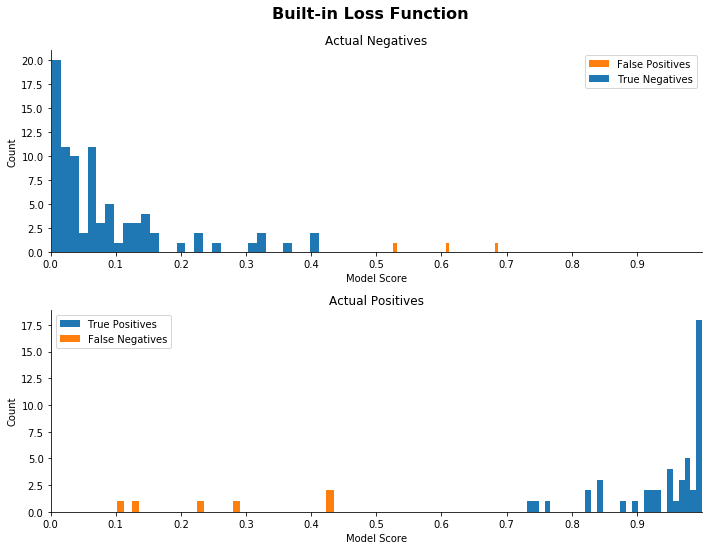

In [41]:
custom_pred_distro(y_builtin_pred_pos, y_builtin_pred_neg, cutoff, title='Built-in Loss Function')

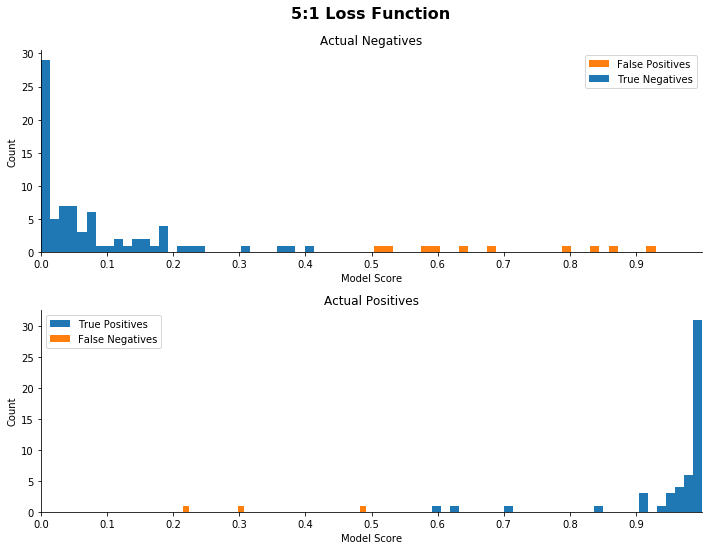

In [42]:
custom_pred_distro(y_five_pred_pos, y_five_pred_neg, cutoff, title='5:1 Loss Function')

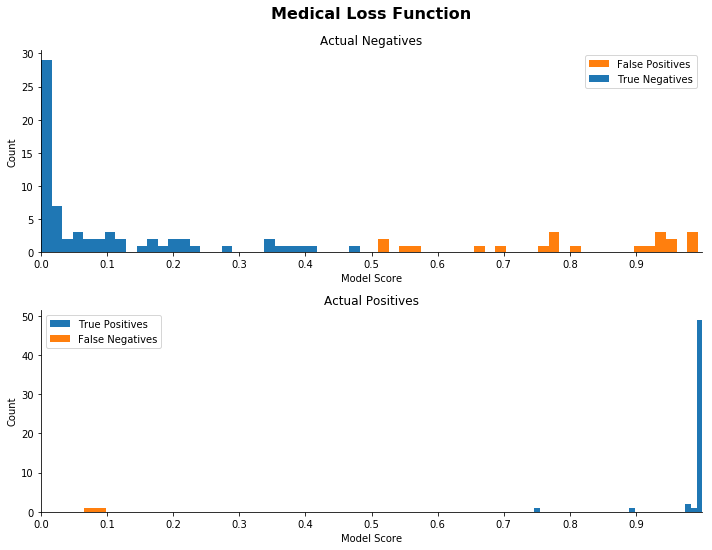

In [43]:
custom_pred_distro(y_medical_pred_pos, y_medical_pred_neg, cutoff, title='Medical Loss Function')

We can see from these plots that as we increase the ratio, the distributions shift. As the ratio between the error types increases, the model pushes a larger number of samples to the extremes, essentially becoming much more discriminatory.

We can also see that few of our actual positives have scores close to the cutoff. The model is demonstrating increased "certainty" in its classifications of the positives. 

Note that in many of our runs, 1 observation - #38 - is the lone incorrectly classified actual positive. This observation may have some different characteristics from the others, that may be indicative of a rare and different pattern that bears additional investigation. 

#### Expected Value

We now calculate the expected value (economic value) of each of the three classification models. The expected value captures the probability-weighted loss expressed in US dollars that an individual patient is expected to suffer if given a specific diagnostic test. The diagnostic test with the highest expected value is considered the “best” under this metric. The expected value is stated in US dollars.

For an explanation of QALY and the dollar values associated with testing outcomes defined in the following cell, see the discussion of screening costs earlier in this blog post.

In [44]:
dollar_per_qaly = 100000
v_tn = 0 * dollar_per_qaly
v_fp = -0.0128767 * dollar_per_qaly
v_fn = -2.52 * dollar_per_qaly
v_tp = -0.3528 * dollar_per_qaly

Note that in this section we are now reflecting the value of all four possible test outcomes - true and false negatives, as well as true and false positives.

In [45]:
ev_builtin = expected_value(y_builtin_pred_pos, y_builtin_pred_neg, v_tn=v_tn, v_fp=v_fp, v_fn=v_fn, v_tp=v_tp)
ev_five = expected_value(y_five_pred_pos, y_five_pred_neg, v_tn=v_tn, v_fp=v_fp, v_fn=v_fn, v_tp=v_tp)
ev_medical = expected_value(y_medical_pred_pos, y_medical_pred_neg, v_tn=v_tn, v_fp=v_fp, v_fn=v_fn, v_tp=v_tp)

In [46]:
df_ev = pd.DataFrame(data = [ev_builtin['ev'], ev_five['ev'], ev_medical['ev']], 
            index = ['Builtiin', '5:1', 'Medical'], 
            columns=['Expected Value'])

def currency_format(x):
    if x >= 0:
        return '${:,.2f}'.format(x)
    else:
        return '-${:,.2f}'.format(abs(x))
    
df_ev['Expected Value'] = df_ev['Expected Value'].map(currency_format)

df_ev

,Expected Value
Builtiin,"-$22,689.39"
5:1,"-$18,205.85"
Medical,"-$15,273.85"


The binary classifier trained with the custom loss function based upon the costs reported in the medical literature is the least costly of the three.

Note that while we used QALY values to train the model and also to evaluate the economic cost, it is not necessary to use the same values. This provides a second powerful lever to use in influencing, understanding and evaluating the model.

Now that we have demonstrated how to train the classifier with a custom loss function and inspected the results, feel free to experiment with different relative values for FN and FP, and with different costs, and explore the impact.

### Conclusion<a id='conclusion'></a>

In the example worked in this blog post, we've shown how to use a custom loss function to modify the balance of FN and FP errors. We've shown that we can impact that balance separately from the costs of different kinds of treatment plans applied to each set of predictions.

There are several ways in which this work can be extended. Promising avenues include:
* Using the relative loss and the economic costs as hyperparameters and exploring the hyperparameter space to find optimal trade-offs. 
* Exploring different or more complex cost functions, including making the costs dependent on specific features within an observation. 
* Further exploration and understanding of how the model changes with different relative costs, and the features most relevant to those changes.

We've shown the approach applied to a binary classification problem, however, it is generalizable to multiclass classification problems. Designing the input cost matrix that accurately (or adequately) reflects the costs of different kinds of errors or misclassifications is more challenging. For example, identifying a stop sign as a 45 mph sign will probably not have the same cost or consequences as the reverse. However, a model trained with this understanding could provide a better overall economic value than one trained to simply maximize precision, recall, F1-score, or AUC.

In this blog post, we've shown the power of using a custom loss function to represent the true impacts of different kinds of errors. The custom loss function allows us to choose the relative balance of the types of errors made by the model, and to evaluate the economic impact of changing that balance. Visualizing the resulting score distributions lets us evaluate the discriminatory power of the model. We can also evaluate the costs and tradeoffs of different approaches for the different predictions and their errors. This combination gives the business a powerful new tool to link machine learning to business results, providing greater transparency to the trade-offs being made.

Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.  
SPDX-License-Identifier: MIT-0